In [1]:
#Goal is to use advanced pymc3 and AR/SARIMA/SARIMAX modeling to predict further into the future than just one prediction.

In [2]:
#In this notebook we will use pymc3 to approximate a carrying capacity curve for an athlete, and use it to determine when to approximate pace with
#the linear AR time series model.

From Wikipedia:
Carrying Capacity

![Carrying Capacity](images/1200px-Logistic_Carrying_Capacity.svg.png)

In [3]:
#I am going to attempt to model the carrying capacity of an athlete's training, and use it to predict when is a good time to use the linear correlation of training
#paces, and hopefully predict further into the future than just one day.

In [4]:
#Similar to a population, an athlete will reach a theoretical limit of training factors that will help determine the pace achievable on race day.

In [5]:
#Imports borrowed from pymc3_modeling.ipynb
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from scipy.integrate import odeint
size = (12, 9)

import json
import datetime as dt

import re
import os
import glob

import arviz as az
import theano
import theano.tensor as tt
import statsmodels.api as sm
import pymc3 as pm
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from pandas.plotting import register_matplotlib_converters
plt.style.use('seaborn')
register_matplotlib_converters()


In [6]:
pm.__version__

'3.8'

In [7]:
az.__version__

'0.10.0'

In [8]:
#Read in the athlete dictionary:
with open("./data/athletes.json") as json_file: 
    athletes = json.load(json_file)

In [9]:
def analyze_file(filepath, sport, athlete_id): #Athlete id is a number no need to pass it the string:
    '''
    This function takes in a file, converts all the columns to numeric and date that we need,
    creates a speed column for running that converts pace to speed in ft/s, and prepares the 
    columns for the fit function that will later be used to predict the running pace. It will 
    create and output all the graphs we have here, for each of the races in the filepath.
    '''
    #Read in the dataframe:
    raw = pd.read_csv(filepath)
    sport = sport
    athlete_max_hr = athletes[str(athlete_id)]['max_hr']
    #Filter down just to the sport:
    df = raw[raw['activity_type'] == sport]
    
    
    #Setting average pace to a timedelta, we use a try in case the data does not have avg_pace column:
    try:
        df['avg_pace'] = pd.to_timedelta(df['avg_pace'])
    except:
        print("No avg_pace column!")
    
    try:
        df['distance'] = pd.to_numeric(df['distance'])
    except:
        print(f"Check athlete #{athlete_id} at filepath ###{filepath}###")
    
    try:
        df['elev_gain'] = pd.to_numeric(df['elev_gain'].str.replace(',', ''))
    except:
        try:
            df['elev_gain'] = pd.to_numeric(df['elev_gain'])
        except:
            print(f"Check athlete #{athlete_id} at filepath ###{filepath}###")
    
    #Create ft/mile column and intensity for analysis:
    df['ft_per_mile'] = (df['elev_gain']/df['distance'])
    df['intensity'] = df['avg_hr']/athlete_max_hr
    
    
    
    #Do the same for calculating speed in ft/s
    df['spd_ft_s'] = 0.0
    df['spd_mph'] = 0.0
    df.reset_index(inplace=True)
    
    for i in range(len(df['avg_pace'])):
        #.total_seconds returns the total seconds in a timedelta object.
        df['spd_mph'][i] = float(60/(df['avg_pace'][i].total_seconds()/60.0))
        #takes the speed in miles per hour and converts down to ft/s
        df['spd_ft_s'][i] = float(60.0/(df['avg_pace'][i].total_seconds()/60.0))*float(5280.0/3600.0)
        
    #The default is to be equal to the speed not taking into account elevation gain.
    df['GAP_ft_s'] = df['spd_ft_s']
    
    #Now we try to make a GAP column:
    for i in range(len(df)):
        #Try to make a GAP column:
        try:
            #using trig to calculate the change to the pace:
            factor = (np.sqrt((df['distance'][i]*5280)**2+df['elev_gain'][i]**2)/(df['distance'][i]*5280))
            df['GAP_ft_s'][i] = factor*df['spd_ft_s'][i]
        except:
            print("No GAP_ft_s was able to be calculated. Data is equal to spd_ft_s.")
        
    #Why divide by intensity? This brings average run pace up to the speed that we would expect if the athlete was at their highest average
    #sustainable heartrate for this speed. 
    df['GAP_by_intensity']  = df['GAP_ft_s']/df['intensity']
    
    #This creates a finalized dataframe with all of the columns I need for creating the pace curves.
    df.to_csv(filepath[:-4]+'_'+sport+'_extra_cols.csv')

In [10]:
#I have this here so we can perform it on other clean data if necessary.

In [11]:
clean_running = pd.read_csv('./data/clean/garmin_clean/clean_3_Running_extra_cols.csv', index_col='date').drop('date.1', axis=1)

In [12]:
#Let's pull out just the columns we want:

In [13]:
clean_running.tail(2)

,Unnamed: 0,index,activity_type,favorite,title,distance,calories,time,avg_hr,max_hr,...,max_resp,athlete_id,filetype,is_race,ft_per_mile,intensity,spd_ft_s,spd_mph,GAP_ft_s,GAP_by_intensity
date,,,,,,,,,,,,,,,,,,,,,
2017-12-14 18:11:31,666,2337,Running,False,Lafayette Running,5.27,626,00:45:18,139,155,...,0,3,garmin,0,37.381404,0.776536,10.252427,6.990291,10.252684,13.203097
2017-12-13 18:31:24,667,2339,Running,False,Lafayette Running,8.22,964,01:03:31,152,166,...,0,3,garmin,0,30.778589,0.849162,11.379310,7.758621,11.379504,13.400863


In [14]:
clean_running.columns

Index(['Unnamed: 0', 'index', 'activity_type', 'favorite', 'title', 'distance',
       'calories', 'time', 'avg_hr', 'max_hr', 'aerobic_te', 'avg_run_cadence',
       'max_run_cadence', 'avg_pace', 'best_pace', 'elev_gain', 'elev_loss',
       'avg_stride_length', 'avg_vertical_ratio', 'avg_vertical_oscillation',
       'avg_ground_contact_time', 'avg_gct_balance', 'avg_run_cadence_1',
       'max_run_cadence_1', 'normalized_powerâ_npâ', 'lr_balance',
       'training_stress_scoreâ', 'max_avg_power_20_min', 'avg_power',
       'max_power', 'grit', 'flow', 'total_strokes', 'avg__swolf',
       'avg_stroke_rate', 'total_reps', 'total_sets', 'climb_time',
       'bottom_time', 'min_temp', 'surface_interval', 'decompression',
       'best_lap_time', 'number_of_laps', 'max_temp', 'avg_resp', 'min_resp',
       'max_resp', 'athlete_id', 'filetype', 'is_race', 'ft_per_mile',
       'intensity', 'spd_ft_s', 'spd_mph', 'GAP_ft_s', 'GAP_by_intensity'],
      dtype='object')

In [15]:
df = clean_running[['index', 'avg_hr', 'max_hr', 'elev_gain', 'elev_loss', 'athlete_id', 'is_race', 'ft_per_mile',
       'intensity', 'spd_ft_s', 'spd_mph', 'GAP_ft_s', 'GAP_by_intensity']]

In [16]:
#Get to a usable datetime:
df.index = pd.to_datetime(df.index).normalize()

In [17]:
#Remove duplicate entries:
df = df[~df.index.duplicated(keep='first')]

In [18]:
full_date_range = pd.date_range(start = '2017-12-14', end='2021-01-01')

In [19]:
df = df.reindex(index = full_date_range)

In [20]:
df.isna().sum()

index               514
avg_hr              514
max_hr              514
elev_gain           514
elev_loss           514
athlete_id          514
is_race             514
ft_per_mile         514
intensity           514
spd_ft_s            514
spd_mph             514
GAP_ft_s            514
GAP_by_intensity    514
dtype: int64

In [21]:
len(df)

1115

In [22]:
df['spd_padded'] = df['spd_ft_s'].fillna(method='pad')

In [23]:
df['intensity_padded'] = df['intensity'].fillna(method='pad')

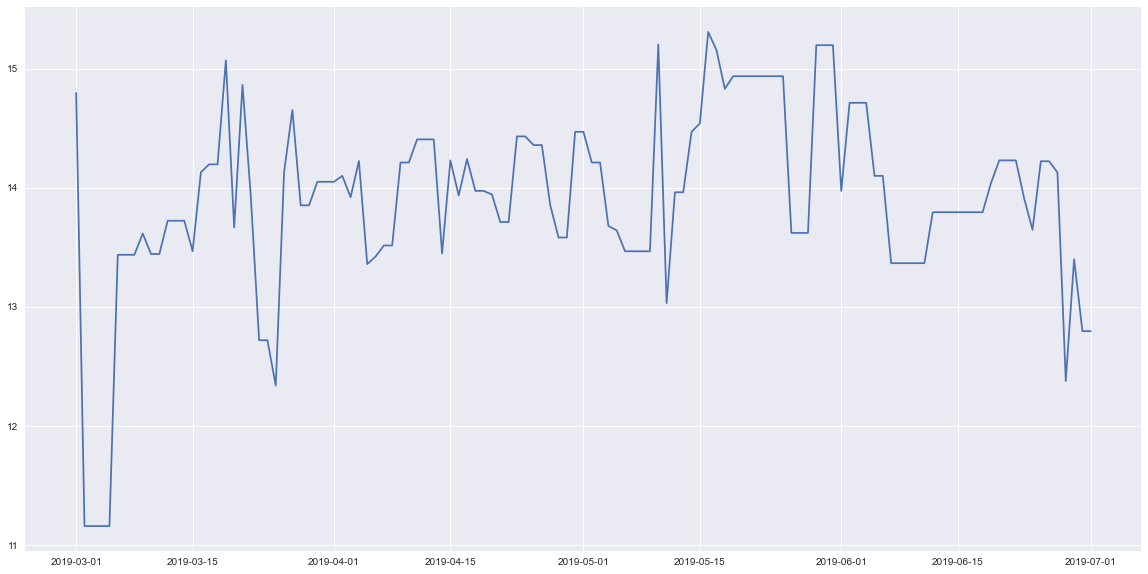

In [24]:
plt.figure(figsize = (20, 10))
plt.plot(df['2019-03-01':'2019-07-01']['spd_padded']/df['2019-03-01':'2019-07-01']['intensity_padded'])

In [25]:
#Let's build the rolling windows:
df['spd_SMA_7'] = df['spd_padded'].rolling(window=7).mean()
df['spd_EMA_7'] = df['spd_ft_s'].ewm(span=7,adjust=False).mean()

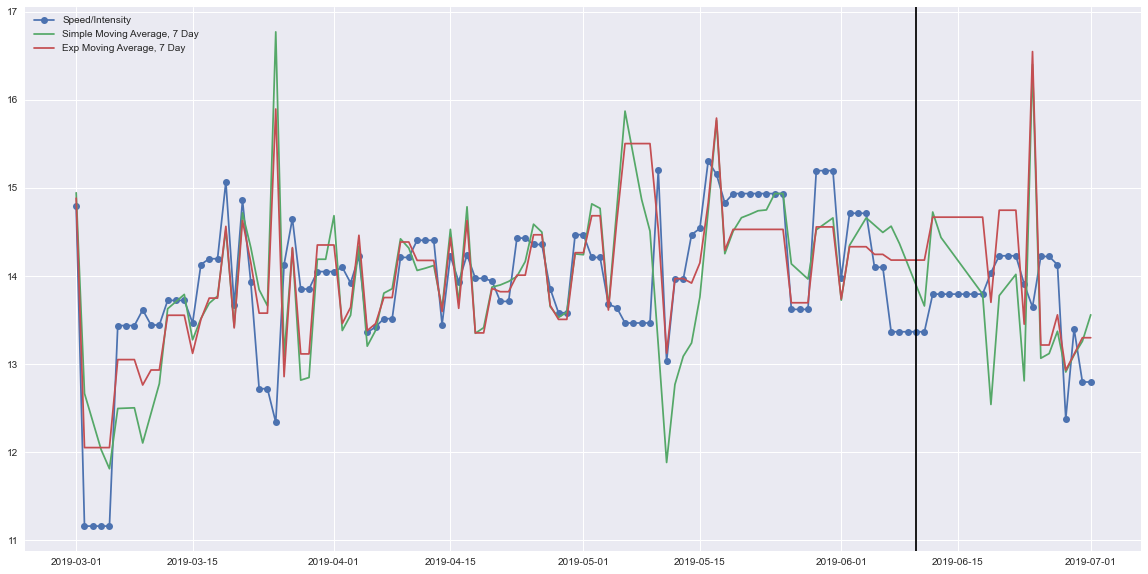

In [26]:
plt.figure(figsize = (20, 10))
plt.plot(df['2019-03-01':'2019-07-01']['spd_padded']/df['2019-03-01':'2019-07-01']['intensity_padded'], '-o', label='Speed/Intensity')
plt.plot(df['2019-03-01':'2019-07-01']['spd_SMA_7']/df['2019-03-01':'2019-07-01']['intensity_padded'], label='Simple Moving Average, 7 Day')
plt.plot(df['2019-03-01':'2019-07-01']['spd_EMA_7']/df['2019-03-01':'2019-07-01']['intensity_padded'], label='Exp Moving Average, 7 Day')
plt.axvline(dt.datetime(2019, 6, 10), color = 'black')
plt.legend()

In [27]:
#What can we tell from this?

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX as smx

In [29]:
model = smx(endog = (df['2019-03-01':'2019-07-27']['spd_EMA_7'].dropna()/df['2019-03-01':'2019-07-27']['intensity_padded']), seasonal_order = (1, 0, 0, 12))

In [30]:
results = model.fit(disp=False)

In [31]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  149
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -175.007
Date:                            Tue, 02 Mar 2021   AIC                            356.015
Time:                                    08:48:46   BIC                            365.026
Sample:                                03-01-2019   HQIC                           359.676
                                     - 07-27-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9986      0.005    221.741      0.000       0.990       1.007
ar.S.L12      -0.0302      0.154   

In [32]:
#Let's narrow down to one race to use, where we know the end race pace:
santa_rosa = df['2019-01-01':'2019-08-15']
santa_rosa['spd_EMA_30'] = santa_rosa['spd_ft_s'].ewm(span=30,adjust=False).mean()

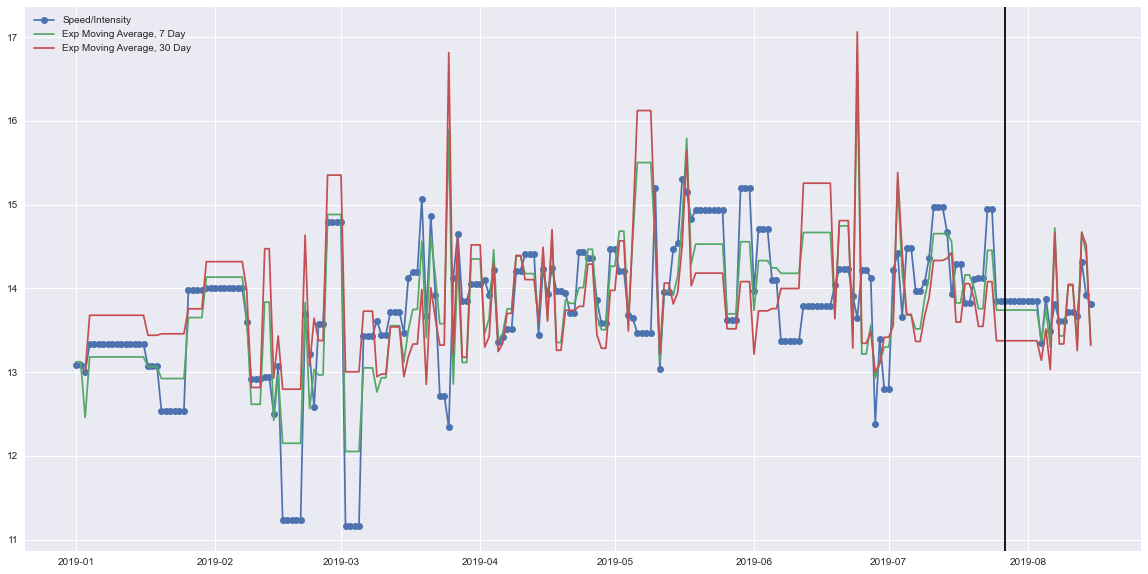

In [33]:
plt.figure(figsize = (20, 10))
plt.plot(santa_rosa['spd_padded']/santa_rosa['intensity_padded'], '-o', label='Speed/Intensity')
plt.plot(santa_rosa['spd_EMA_7']/santa_rosa['intensity_padded'], label='Exp Moving Average, 7 Day')
plt.plot(santa_rosa['spd_EMA_30']/santa_rosa['intensity_padded'], label='Exp Moving Average, 30 Day')
plt.axvline(dt.datetime(2019, 7, 27), color = 'black')
plt.legend()

In [34]:
sr_weekly = santa_rosa.resample('W').mean()

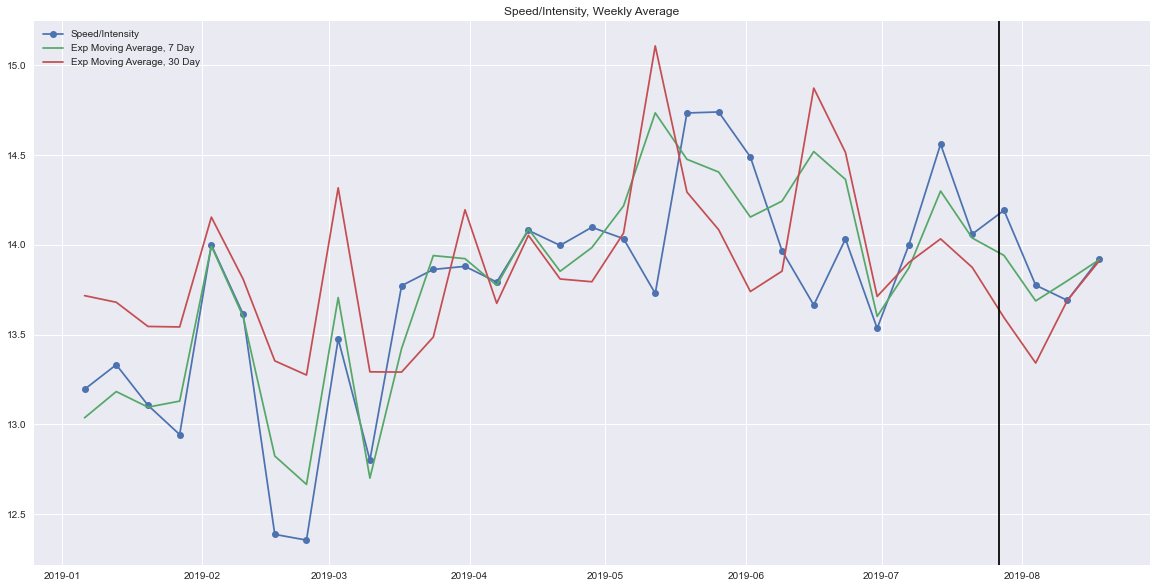

In [35]:
plt.figure(figsize = (20, 10))
plt.plot(sr_weekly['spd_padded']/sr_weekly['intensity_padded'], '-o', label='Speed/Intensity')
plt.plot(sr_weekly['spd_EMA_7']/sr_weekly['intensity_padded'], label='Exp Moving Average, 7 Day')
plt.plot(sr_weekly['spd_EMA_30']/sr_weekly['intensity_padded'], label='Exp Moving Average, 30 Day')
plt.axvline(dt.datetime(2019, 7, 27), color = 'black')
plt.title('Speed/Intensity, Weekly Average')
plt.legend()

$$ S(x) = 1/({1+e^{-x}}) $$

In [36]:
#Is the equation for the sigmoid function. We are going to try and fit it to our curve using pymc3, and then forecast
#along this curve to predict future pacing.

In [37]:
def sigmoid(x):
    
    m = 5
    c = 13.5
    s = .1
    
    return m/(1+np.exp((-(x-c))/s)) + c

In [38]:
var = np.linspace(-50, 50, 1000)

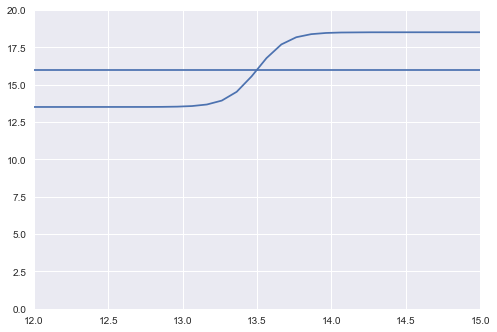

In [39]:
plt.plot(var, sigmoid(var))
plt.xlim(12, 15)
plt.ylim(0, 20)
plt.hlines(16, 0, 100)

In [40]:
def sigmoid2(x):
    
    m = 10
    c = 0
    s = .5
    
    return m/(1+np.exp((-(x-c))/s)) + c + np.random.randn(1000)

(-15.0, 30.0)

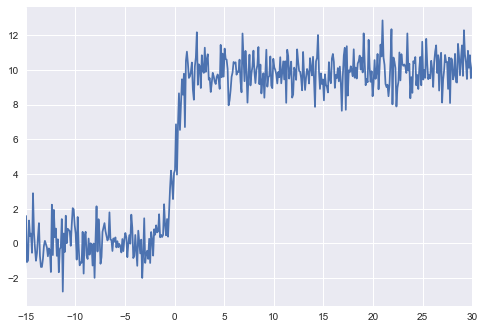

In [41]:
plt.plot(var, sigmoid2(var))
plt.xlim(-15, 30)

In [42]:
#Just for grins, lets see if we can set a start point, a race date, and build a curve simulating it:

In [43]:
start_pace = 10
days_until_race = 100
end_pace = 20

In [44]:
def sigmoid_race(x):
    
    m = end_pace-start_pace
    c = days_until_race/2
    s = 10
    offset = start_pace
    
    return m/(1+np.exp((-(x-c))/s)) + offset + .1*np.random.randn(100)

In [48]:
obs = sigmoid_race(x)
obs

array([ 9.96760205,  9.98921566, 10.09508578, 10.10541625, 10.05971016,
       10.03226342, 10.28010254, 10.06296704, 10.16720391, 10.2423613 ,
       10.14965113, 10.08756386, 10.2408188 , 10.04382838, 10.26289581,
       10.32418128, 10.30688804, 10.44897436, 10.3363842 , 10.3626999 ,
       10.60746649, 10.642618  , 10.52431648, 10.68890236, 10.7372903 ,
       10.79455119, 10.84556097, 10.91859975, 11.04139852, 11.3008897 ,
       11.19813326, 11.34825139, 11.31415191, 11.53215285, 11.87518685,
       12.06469895, 11.90689546, 12.24641169, 12.43030001, 12.50671728,
       12.71855695, 13.01424577, 13.07165055, 13.34212815, 13.56226791,
       13.874985  , 14.17901812, 14.42536211, 14.49297119, 14.83092916,
       15.12270706, 15.47271903, 15.60346158, 16.09899152, 15.93696745,
       16.4294593 , 16.61420621, 16.88460807, 17.13234444, 17.09434489,
       17.4154438 , 17.68323633, 17.74434701, 17.84980378, 18.11747008,
       18.08482006, 18.39165992, 18.5532358 , 18.74085854, 18.76

In [49]:
def sigmoid_clean(x):
    
    m = end_pace-start_pace
    c = days_until_race/2
    s = 10
    offset = start_pace
    
    return m/(1+np.exp((-(x-c))/s)) + offset

In [50]:
x = np.linspace(0, days_until_race, 100)

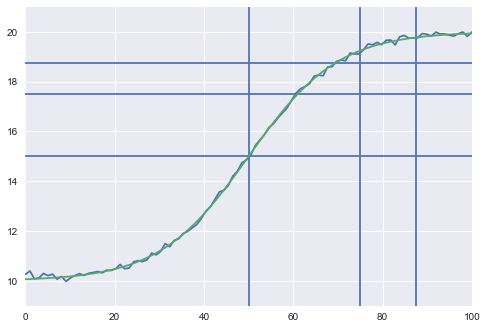

In [51]:
plt.plot(x, sigmoid_race(x))
plt.plot(x, sigmoid_clean(x))
plt.xlim(0, 100)
plt.ylim(9, 21)
plt.vlines([50, 75, 87.5], 0, 50)
plt.hlines([15, 17.5, 18.75], 0, 100)

In [52]:
#So this is the behavior we want to model/predict.
x = np.linspace(0, 100, 100)

with pm.Model() as run_model:
    
    s = pm.Uniform('s', lower = 5, upper = 15)
    c = pm.Uniform('c', lower = 40, upper = 60)
    sd = pm.Uniform('sd', lower = 0, upper = .5)
    offset = pm.Uniform('off', lower = 0, upper = 15)
    line = s/(1+np.exp((-(x-c))/s)) + offset
    y = pm.Normal('y', mu = line, sd = sd, observed = obs)
    
    trace = pm.sample(1000, target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:11<00:00, 500.35draws/s]


In [142]:
trace['s'].mean()

1.1769518593741028

array([[<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>],
       [<AxesSubplot:title={'center':'off'}>,
        <AxesSubplot:title={'center':'off'}>]], dtype=object)

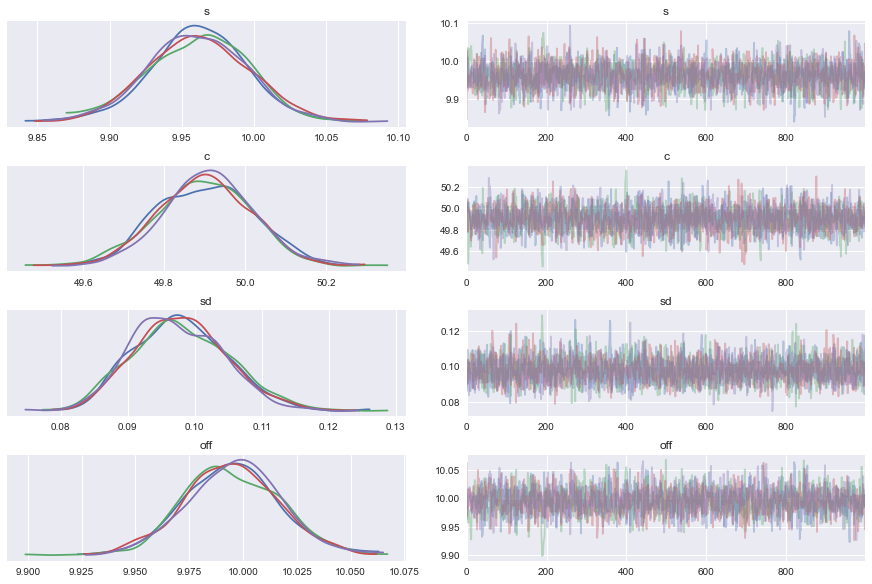

In [53]:
az.plot_trace(trace)

In [54]:
weekly_target = sr_weekly['spd_padded']/sr_weekly['intensity_padded']

In [57]:
len(weekly_target)

33

In [93]:
x = np.linspace(0, 33, 33)

with pm.Model() as run_model:
    
    s = pm.Normal('s', mu = 3, sd = .5)
    c = pm.Normal('c', mu = 16, sd = 5)
    sd = pm.HalfNormal('sd', sd = 5)
    offset = pm.Uniform('off', lower = 10, upper = 14)
    line = s/(1+np.exp((-(x-c))/s)) + offset
    y = pm.Normal('y', mu = line, sd = sd, observed = weekly_target)
    
    trace = pm.sample(1000, target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [off, sd, c, s]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:11<00:00, 516.38draws/s]


array([[<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>],
       [<AxesSubplot:title={'center':'off'}>,
        <AxesSubplot:title={'center':'off'}>]], dtype=object)

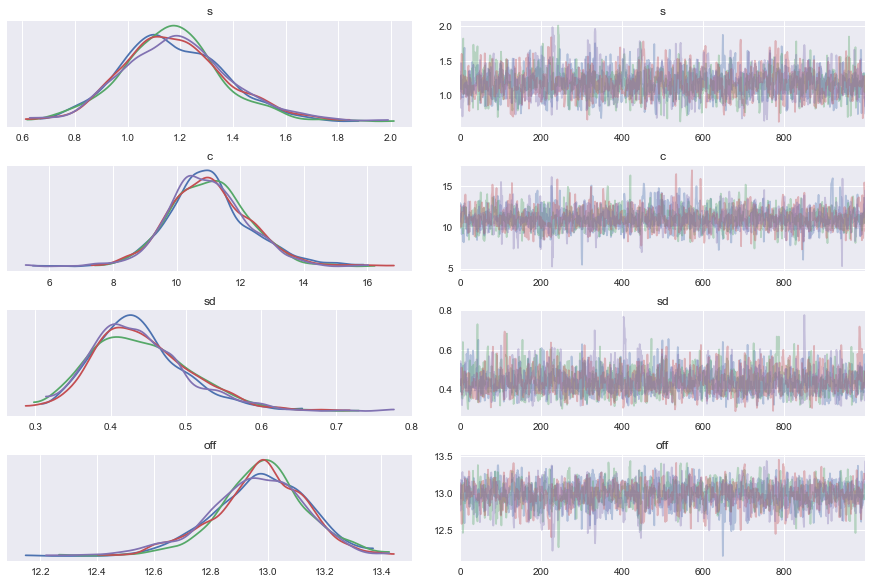

In [94]:
az.plot_trace(trace)

## Generalizing the Curve/Fitting Next Race Data

In [ ]:
#Let's take a look at the next race peried. For starters 

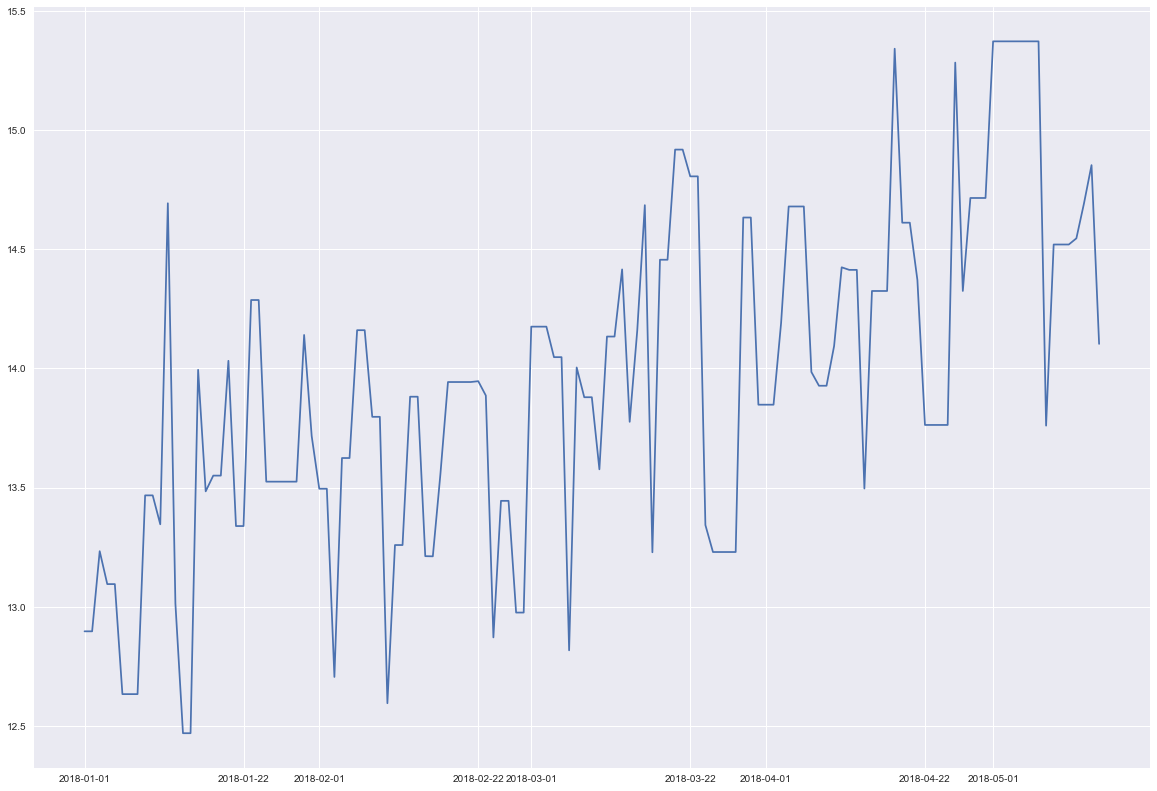

In [102]:
plt.figure(figsize=(20,14))
plt.plot(df['2018-01-01':'2018-05-15']['spd_padded']/df['2018-01-01':'2018-05-15']['intensity_padded'])

In [101]:
race_2 = df['2018-01-01':'2018-05-15']['spd_padded']/df['2018-01-01':'2018-05-15']['intensity_padded']

In [103]:
race_2_w = race_2.resample('W').mean()

In [ ]:
#Pace on race day was 6:51min/mile, or about 12.9 ft/s

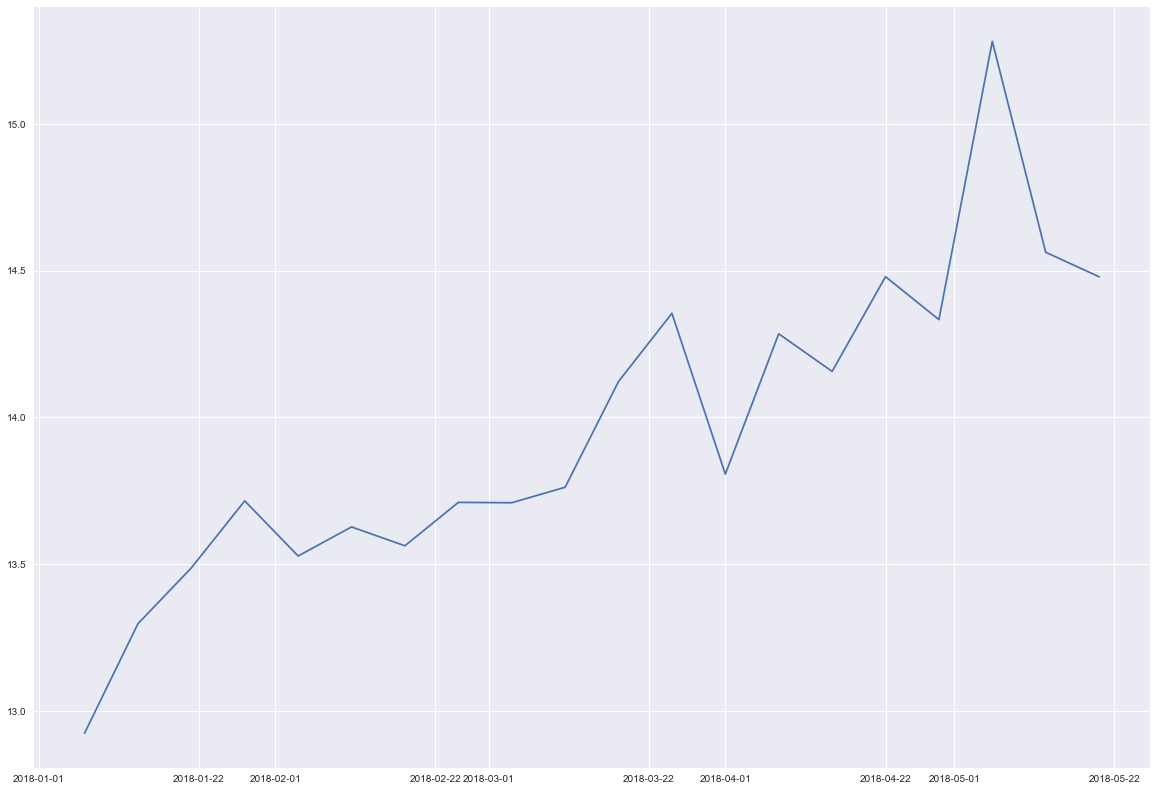

In [104]:
plt.figure(figsize=(20,14))
plt.plot(race_2_w)

In [108]:
len(race_2_w)

20

In [122]:
#Define our midpoint:
new_c = len(race_2_w)/2

We will assume the starting pace is the average of the first 5 paces:

In [152]:
new_offset = race_2_w[:5].mean()
new_offset

13.391293304062804

In [153]:
#For reference:
weekly_target[:5].mean()

13.31484375242825

So our offset is 13.393

In [154]:
#Therefore, our new function is:
def new_line(x):
    return 1.2/(1+np.exp((-(x-new_c))/1.2)) + new_offset

In [155]:
x = np.linspace(0, 20, 20)

In [156]:
new_line(x)

array([13.39137594, 13.39149195, 13.39177077, 13.39244055, 13.39404775,
       13.39789412, 13.40704096, 13.4284679 , 13.47694075, 13.57844591,
       13.7604031 , 14.01102303, 14.25493535, 14.42399792, 14.51553872,
       14.55857701, 14.5774648 , 14.58550238, 14.58887777, 14.59028738])

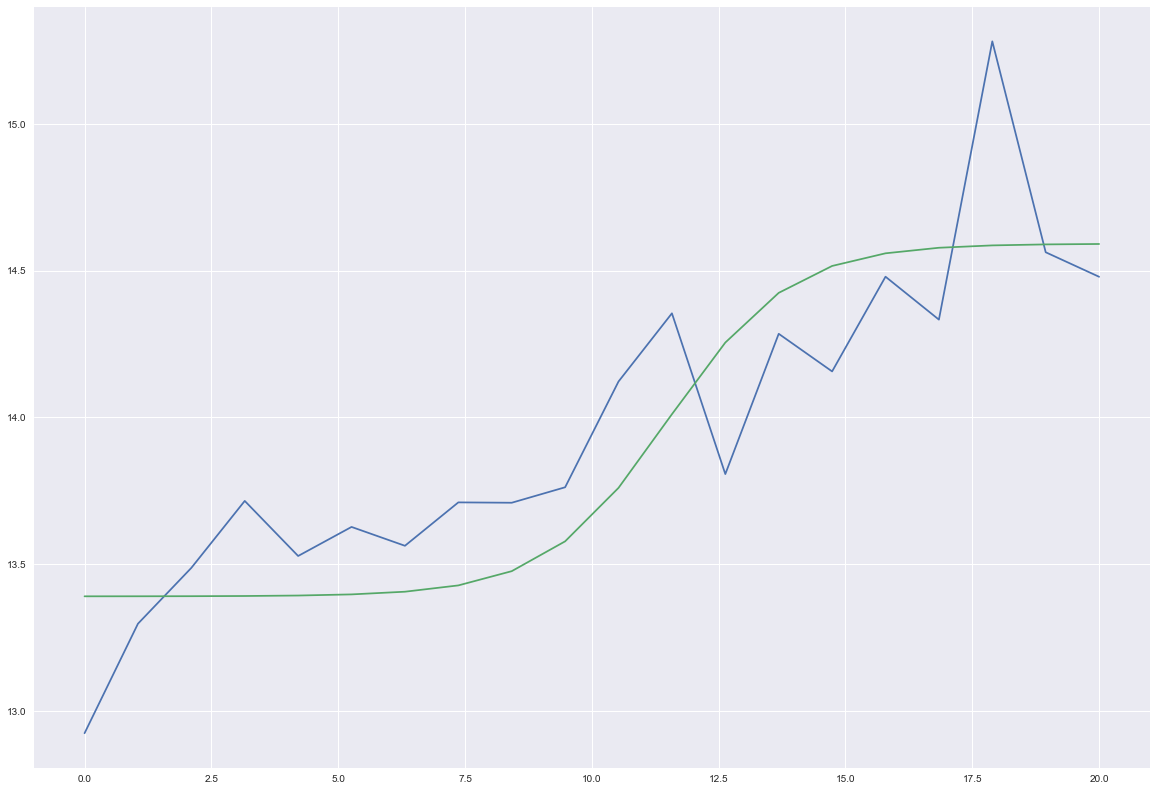

In [157]:
plt.figure(figsize=(20,14))
plt.plot(x, race_2_w)
plt.plot(x, new_line(x))

In [ ]:
#Calculated pace: 6:42. Actual Pace: 6:50. Pretty good.

In [129]:
#Let's see if it holds true for another race that year:

In [130]:
race_3 = df['2019-01-01':'2019-06-09']['spd_padded']/df['2019-01-01':'2019-06-09']['intensity_padded']

In [131]:
#race pace was a little over 8:00/mile, a 3:32 marathon. Marathon pace is commonly ~ .75-.8 of threshold intensity.

In [132]:
race_3_w = race_3.resample('W').mean()

In [133]:
len(race_3_w)

23

In [134]:
#Define our midpoint:
new_c = len(race_3_w)/2

In [135]:
new_offset = race_3_w[:10].mean()
new_offset

13.141595020891515

In [137]:
#Therefore, our new function is:
def new_line(x):
    #1.2 is the s variable we found above, for this athlete
    return 1.2/(1+np.exp((-(x-new_c))/1.2)) + new_offset

In [138]:
x = np.linspace(0, 23, 23)

In [139]:
new_line(x)

array([13.14167766, 13.14179248, 13.14206681, 13.14272189, 13.1442845 ,
       13.1480024 , 13.15679462, 13.17729073, 13.22351416, 13.32040135,
       13.4955976 , 13.74159502, 13.98759244, 14.16278869, 14.25967588,
       14.30589931, 14.32639542, 14.33518764, 14.33890554, 14.34046815,
       14.34112323, 14.34139756, 14.34151239])

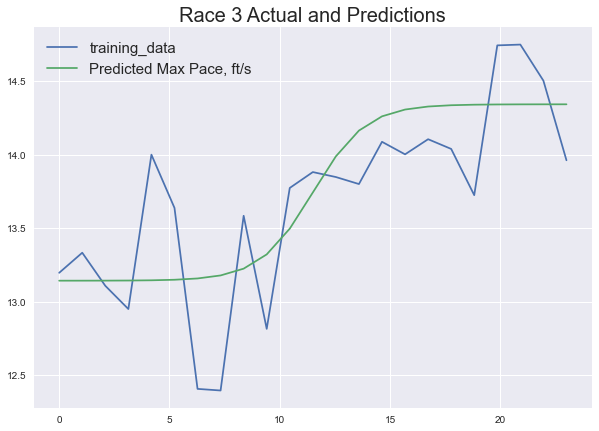

In [151]:
plt.figure(figsize=(10,7))
plt.plot(x, race_3_w, label = 'training_data')
plt.plot(x, new_line(x), label = 'Predicted Max Pace, ft/s')
plt.title("Race 3 Actual and Predictions", fontsize = 20)
plt.savefig('./images/race_3_graph.png')
plt.legend(fontsize = 15)

In [ ]:
#Looks pretty good too.

In [143]:
#Below is for further investigation. 